<a href="https://colab.research.google.com/github/vilsonrodrigues/Projeto_Orientacao_Academica/blob/master/Projeto_Orientacao_Academica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Por @vilsonrodrigues



# <center><font color='blue'>Projeto de Orientação Acadêmica</font>




<img src='https://ufrn.br/resources/documentos/identidadevisual/logotipo/logotipo_flat.png'>

## Parte I - Apresentação do Problema
### [1. Apresentação do Problema](#apresentacao)
## Parte II - Preparativos Iniciais
### [1. Bibliotecas](#bibliotecas)
### [2. Classe](#classe)
### [3. Funções](#funcoes)
### [4. Leituras da Bases](#leiturabase)
## Parte III - Desenvolvimento
### [1. Entendimento dos Dados Primários](#enten_dados)
### [2. Preparação dos Dados](#preparo)
### [3. Exploração dos Novos Dados](#novos_dados)
### [4. Métricas de Avaliação](#metricas)
### [5. Modelagem](#modelagem)
### [6. Avaliação de Modelo](#avaliacao)
### [7. Conclusão](#conclusao)




# Parte I - Apresentação do Problema

### **Meta**
Nossa meta é prever através de Machine Learning as probabilidades de um estudante ter sucesso em uma disciplina dado o histórico escolar na Universidade

Nossos dados foram transformados para ficarem de uma forma génerica, assim, não dependemos de saber qual foi a matéria cursada anteriormente

Com essa plataforma, os professores que orientam alunos, terão mais segurança e uma comprovação com base no Machine Learning que estudantes que tiveram um histórico semelhante e seguiram esse caminho tiveram mais êxito do que seguir por este outro.

Os dados foram coletados do período de 2015.1 até 2019.2

Esse projeto foca em analisar os dados e montar uma estratégia de gerar dados genéricos, de modo que fiquem independente de qual disciplina o aluno curso no semeste anterior. Depois é gerado um modelo classificador usando Machine Learning para prever em cada disciplina da ECT a probabilidade de aprovação e reprovação

### **Fonte dos Dados**
Dados foram extraídos do portal SIGAA e fornecidos pela Escola de Ciências e Tecnlogia (ECT)

### **Referência**
Hands On: Machine Learning with Scikit-Learning e Tensor Flow



# Parte II - Preparativos Iniciais

## 1. Bibliotecas
<a id='bibliotecas'></a>
#### [1.1 Instalações](#instalacao)
#### [1.2 Importações](#importacao)


### 1.1. Instalação
<a id='instalacao'></a>

Se estiver em uma máquina sem, instale

In [0]:
!pip install pandas -U
!pip install scikit-learn -U
!pip install numpy -U

Necessário instalar a versão específica afim de evitar incompatibilidade

In [0]:
!pip install joblib==0.15.1

### 1.2. Importação
<a id='importacao'></a>

In [0]:
import pandas as pd
import numpy as np

#Persistência em disco
import joblib
import pickle

#Visualização
import seaborn as sns
import matplotlib.pyplot as plt

#Transformadores e Modelador
from sklearn.pipeline           import Pipeline
from sklearn.preprocessing      import StandardScaler
from sklearn.preprocessing      import label_binarize
from sklearn.base               import BaseEstimator 
from sklearn.base               import TransformerMixin

#Selecao de modelo
from sklearn.model_selection    import train_test_split
from sklearn.model_selection    import KFold
from sklearn.model_selection    import cross_val_score
from sklearn.model_selection    import GridSearchCV
from sklearn.feature_selection  import SelectKBest
from sklearn.feature_selection  import chi2

#Metricas
from sklearn.metrics            import classification_report
from sklearn.metrics            import confusion_matrix
from sklearn.metrics            import make_scorer
from sklearn.metrics            import accuracy_score
from sklearn.metrics            import f1_score
from sklearn.metrics            import recall_score
from sklearn.metrics            import precision_score

#Classificadores
from sklearn.ensemble           import RandomForestClassifier
from xgboost                    import XGBClassifier
from sklearn.tree               import DecisionTreeClassifier
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.naive_bayes        import GaussianNB
from sklearn.svm                import SVC
from sklearn.neural_network     import MLPClassifier
from sklearn.linear_model       import SGDClassifier
from sklearn.linear_model       import LogisticRegression
from sklearn.ensemble           import AdaBoostClassifier

#modo não-perturbe
import warnings
warnings.filterwarnings("ignore")

##2. Classe
<a id='classe'></a>


Classe para realizar a geração de dados genéricos

In [0]:
class GeraDadosGenericos(TransformerMixin):  
  def __init__(self, carga):
    self.carga = carga

	#nao irei fazer nenhum treinamento	
  def fit(self, X, y = None):
    return self    

  #-------------------------funcoes de geracao de dados da classe---------------------------------

  def filtraSituacoes(self, df_notas):
    #conversao para string
    df_notas['matricula'] = df_notas['matricula'].astype(str)
    df_notas['periodo']   = df_notas['periodo'].astype(str)

    #substitui todas as situacoes de reprovado e aprovado para ser apenas um tipo
    df_notas.loc[df_notas['situacao'].str.contains('REPROVADO'), 'situacao'] = 'REPROVADO'
    df_notas.loc[df_notas['situacao'].str.contains('APROVADO'), 'situacao']  = 'APROVADO'

    #seleciona as situacoes de interesse que são aprovados e reprovados
    df_notas = df_notas.loc[(df_notas['situacao'].str.contains('APROVADO')) |
                            (df_notas['situacao'].str.contains('REPROVADO')) 
                           ] 	
                           
    #tem disciplina que só contam para a horas complementares, não tem nota
    df_notas = df_notas.loc[ ~(df_notas['nota'].str.contains('-')), :]

    #conversao para de string para float
    df_notas['nota'] = df_notas['nota'].astype(float)
    return df_notas


  def converteString(self, df_notas):
    df_notas['periodo']   = df_notas['periodo'].astype(str)
    return df_notas


  def concatenaSemestre(self, df_notas):
    #pega o ano mais alto que tem na matricula, indicando o semestre do df
    ano_df = df_notas['matricula'].str[0:4].max()
    df_notas['semestre'] = str(ano_df) + '.' + str(df_notas['periodo'].iloc[0])
    #apagando a coluna periodo, nao serve mais
    df_notas.drop(columns = ['periodo'], inplace=True)
    #conversao para float
    df_notas['semestre'] = df_notas['semestre'].astype(float)
    df_notas['matricula'] = df_notas['matricula'].astype(int)
    return df_notas

  #adiciona quanto tempo o estudante esta com a matricula vingente 
  def anosMatriculado(self, df_notas): 
    df_notas['matricula'] = df_notas['matricula'].astype(str)
    df_notas['anoIngresso'] = df_notas['matricula'].str[0:4]
    df_notas['anoIngresso'] = df_notas['anoIngresso'].astype(float)
    df_notas['semestre'] = df_notas['semestre'].astype(float)
    df_notas['anosMatriculado'] = df_notas['semestre'] - df_notas['anoIngresso']
    df_notas['anosMatriculado'] = df_notas['anosMatriculado'].astype(int)
    return df_notas    


  #essa função vai criar as novas features com o desempenho do aluno no semestre 
  def geraFeaturesComDadosGenericos(self, df_notas):
    df_notas = df_notas.merge(self.carga, on = 'codigo')
    df = pd.DataFrame()
    final = pd.DataFrame()

    #media das disciplinas
    df = df_notas.groupby('matricula')['nota'].mean().reset_index()
    df.rename(columns={'nota':'mediaNotas'}, inplace = True)
    final = df

    #menor nota
    df = df_notas.groupby('matricula')['nota'].min().reset_index()
    df.rename(columns = {'nota':'menorNota'}, inplace = True)
    final = final.merge(df, on = 'matricula', how = 'outer')

    #maior nota
    df = df_notas.groupby('matricula')['nota'].max().reset_index()
    df.rename(columns = {'nota':'maiorNota'}, inplace = True)
    final = final.merge(df, on = 'matricula', how = 'outer')

    #quantidade de disciplinas cursadas
    df = df_notas.groupby('matricula')['codigo'].count().reset_index()
    df.rename(columns = {'codigo':'quantidadeDisciplinasCursadas'}, inplace=True)
    final = final.merge(df, on = 'matricula', how = 'outer')

    #quantidade de situacoes
    df = df_notas.groupby(['matricula','situacao'])['codigo'].count().reset_index()
    df.rename(columns = {'codigo':'quanSituacao'}, inplace = True)

    #quantidade de situacoes em que houve aprovacao
    aprovado = df.loc[df['situacao'] == 'APROVADO',:]
    aprovado.rename(columns = {'quanSituacao':'quantidadeAprovacoes'}, inplace = True)
    final = final.merge(aprovado, on = 'matricula', how = 'outer')

    #quantidade de situacoes em que houve reprovacao
    reprovado = df.loc[df['situacao'] == 'REPROVADO',:]
    reprovado.rename(columns = {'quanSituacao':'quantidadeReprovacoes'}, inplace = True)
    final = final.merge(reprovado, on = 'matricula', how = 'outer')
    final = final.drop(['situacao_x', 'situacao_y'], axis = 1)

    #media das aprovacoes
    aprov = df_notas.loc[df_notas['situacao'] == 'APROVADO',:]
    dfa = aprov.groupby(['matricula'])['nota'].mean().reset_index()
    dfa.rename(columns = {'nota':'mediaAprovadas'}, inplace = True)
    final = final.merge(dfa, on = 'matricula', how ='outer')

    #media das reprovacoes
    reprov = df_notas.loc[df_notas['situacao'] == 'REPROVADO',:]
    dfr = reprov.groupby(['matricula'])['nota'].mean().reset_index()
    dfr.rename(columns = {'nota':'mediaReprovadas'}, inplace = True)
    final = final.merge(dfr, on = 'matricula', how ='outer')

    #carga horaria total no semestre
    df = df_notas.groupby('matricula')['ch_total'].sum().reset_index()
    df.rename(columns = {'ch_total':'cargaHoraria'}, inplace = True)
    final = final.merge(df, on = 'matricula', how = 'outer')

    #substituindo valores nulos por 0
    final = final.fillna(0)

    #conversao de campos de objeto para inteiro
    final['quantidadeAprovacoes']  = final['quantidadeAprovacoes'].astype(int)
    final['quantidadeReprovacoes'] = final['quantidadeReprovacoes'].astype(int)

    #Criando campo taxa de sucesso, que será a porcentagem de aprovações dado o total de disciplinas
    final['taxaDeSucesso']  = np.divide(final['quantidadeAprovacoes'], final['quantidadeDisciplinasCursadas']) 

    #herdando o semestre
    final['semestre'] = df_notas['semestre']

    return final

  #--------------------fim das funcoes de geracao de dados da classe-----------------------------------------


  def transform(self, X, y = None):
    #itera a lista
    lista_df_notas = X.copy()
    lista_df_generico = []
    lista_notas = []
    lista_de_listas = []
    for df_notas in lista_df_notas:
      df_notas = self.converteString(df_notas)
      df_notas = self.filtraSituacoes(df_notas)
      df_notas = self.concatenaSemestre(df_notas)
      lista_notas.append(df_notas)
      df_generico = self.geraFeaturesComDadosGenericos(df_notas)
      df_generico = self.anosMatriculado(df_generico)
      lista_df_generico.append(df_generico)

    lista_de_listas.append(lista_df_generico)  
    lista_de_listas.append(lista_notas)
    return lista_de_listas

**Classes para o treinamento do modelo**

Classe para concatenar os dados genéricos do semestre passado com o resultado final na disciplina no atual semestre

In [0]:
class ConcatenaSemestrePassadoComResultadosDoAtual(TransformerMixin):
  def __init__(self, data = None):
    return data

	#nao irei fazer nenhum treinamento	
  def fit(self, X, y = None):
    return self    

  #--------------------------------- funcoes de transformacao da classe -----------------------------------------
  def converteParaInt(self, df):
    df['matricula'] = df['matricula'].astype(int)
    return df


  def transformacoesSemestreAntecessor(self, semestreAntecessor):
    semestreAntecessor = self.converteParaInt(semestreAntecessor)
    semestreAntecessor.rename(columns = {'cargaHoraria':'cargaHorariaPassada',
                                         'semestre':'semestrePassado'}, 
                                        inplace=True) 
    return semestreAntecessor


  def transformacoesSemestreAtual(self, semestreAtual): 
    semestreAtual = self.converteParaInt(semestreAtual)
    #seleciona os campos que vou precisar
    semestreAtual = semestreAtual[['matricula','cargaHoraria','semestre','quantidadeDisciplinasCursadas','anosMatriculado']]
    semestreAtual.rename(columns = {'cargaHoraria':'cargaHorariaAtual',
                                    'quantidadeDisciplinasCursadas':'quantidadeDisciplinasAtuais',
                                    'semestre':'semestreAtual'}, 
                                    inplace=True) 
    return semestreAtual


  def transformacoesResultadoAtual(self, resultadoAtual):  
    resultadoAtual = self.converteParaInt(resultadoAtual)
    #seleciona os campos que vou precisar
    resultadoAtual = resultadoAtual[['codigo','matricula','disciplina','situacao']] ###colocar o nome da disciplina
    #cria campo vezes reprovado
    resultadoAtual["vezesReprovado"] = 0
    return resultadoAtual


  def mergeTriploTabelas(self, semestreAntecessor, semestreAtual, resultadoAtual):
    dfCompleto = pd.merge(pd.merge(semestreAntecessor, resultadoAtual, on = 'matricula'), 
                          semestreAtual.drop(columns = ['anosMatriculado']), 
                          on = 'matricula')
    return dfCompleto


  def insereVerificaReprovacoes(self, dfCompleto, df_teste):
    #df temporario para armazenar as consultas com resultados iguais
    dftemporario = pd.DataFrame()
    #itera na lista de notas para achar se o aluno ja reprovou em um semestre anterior ao atual
    for df in df_teste[1]:
      #se eh anterior ao atual semestre
      if dfCompleto['semestreAtual'].max() > df['semestre'].max():
        #vou juntar onde no passado do aluno ele cursou a disiciplina para verificar se ele ja foi reprovado, 
        #se aparecer um caso é porque ele ja pagou a disciplina antes, e consequentemente já reprovou
        merge = pd.merge(dfCompleto[['matricula','codigo','vezesReprovado']], df[['matricula','codigo']], 
                        on = ['matricula','codigo'], how = 'inner')
        #todas as iterações que cumprirem o criterio são acumuladas no df
        dftemporario = pd.concat([dftemporario,merge])
    #agrupa por disciplina, para caso tenha mais de uma reprovacao ele contar. Armazena o valor em vezesReprovado    
    dftemporario = dftemporario.groupby(['matricula','codigo'])['vezesReprovado'].count().reset_index().sort_values(by = 'matricula')
    #junta ao df do semestre atual onde tem o mesmo codigo e a matricula, e junta com outer para manter quando nao tiver reprovacao
    dftemporario = pd.merge(dfCompleto.drop(columns = ['vezesReprovado']), dftemporario, on = ['matricula','codigo'], how = 'outer')
    #substitui onde tiver NaN por 0
    dftemporario.fillna(0, inplace = True) 
    #converter de float para inteiro para ficar mais agradavel
    dftemporario['vezesReprovado'] = dftemporario['vezesReprovado'].astype(int)
    return dftemporario

  def concatena(self, lista):
    df = pd.DataFrame()
    for i in lista:
      df = pd.concat([df,i])
    return df.reset_index().drop(columns = ['index'])

  #--------------------------------------------------------fim----------------------------------------------------------------------

  def transform(self, X, y = None):
    df_nota_generico = X.copy()
    lista_df_completos = []
    for i in range (len(df_nota_generico[0]) - 1):
      semestreAntecessor = df_nota_generico[0][i]
      semestreAtual = df_nota_generico[0][i+1]
      resultadoAtual = df_nota_generico[1][i+1]
      semestreAntecessor = self.transformacoesSemestreAntecessor(semestreAntecessor)
      semestreAtual = self.transformacoesSemestreAtual(semestreAtual)
      resultadoAtual = self.transformacoesResultadoAtual(resultadoAtual)
      #juntando tabelas
      dfCompleto = self.mergeTriploTabelas(semestreAntecessor, semestreAtual, resultadoAtual)
      #envia a tabela com o resultado atual e os dados genericos do semestre anterior, e todos os resultados
      #verifica se nos semestres anteriores o aluno ja pagou essa disciplina, consequentemente, ja reprovou nela
      resultado = self.insereVerificaReprovacoes(dfCompleto, df_nota_generico)
      #adiciona o df do semestre a cada iteracao
      lista_df_completos.append(resultado)
    #concatena todos os semestres para retornar 1 so df
    return self.concatena(lista_df_completos)

Classe para discretizar as colunas de notas e carga horária 

In [0]:
class DiscretizaDadosTreino(TransformerMixin):
  def __init__(self, dado = None):
    self.dado = dado
  
  def fit(self, X, y = None):
    return self

  #-----------------------------------------funcoes de discretizacao------------------------------

  #vai receber o nome da coluna para discretizar em intervalos
  def discretizaNotas(self, df, coluna):
    df[coluna+'_cat'] = pd.cut(x = df[coluna], 
                                 bins=[0, 5, 7, 10], 
                                 labels=['baixa','media','alta'] ,
                                 right=False)                                 
    return df

  def discretizaCargaHoraria(self, df, coluna):
    label = ['muito_baixa','baixa','media','alta'] 
    #conversao para inteiro
    df[coluna] = df[coluna].astype(float)
    df[coluna+'_cat'] = pd.cut(x = df[coluna],
                                 bins = [0, 120, 280, 420, 900],
                                 labels = label,
                                 right=False)
    return df

  #--------------------------------------------------------------------------------------------------
  
  def transform(self, X, y = None):
    df = X.copy()
    colunas_notas = ['menorNota','maiorNota','mediaNotas','mediaAprovadas','mediaReprovadas']
    colunas_carga = ['cargaHorariaAtual','cargaHorariaPassada']
    for coluna in colunas_notas:
      df = self.discretizaNotas(df, coluna)
    for col in colunas_carga:
      df = self.discretizaCargaHoraria(df, col)
    df['situacao_binarie'] = label_binarize(df['situacao'], classes=['REPROVADO','APROVADO'])
    df['matricula'] = df['matricula'].astype(str)
    return df

**Classes para a predição do modelo**

Classe para concatenação e transformação das tabelas de predição 

In [0]:
class TranformaDadosGenericosPredicao(TransformerMixin):
  def __init__(self, data = None):
    return data

	#nao irei fazer nenhum treinamento	
  def fit(self, X, y = None):
    return self    

  #--------------------------------- funcoes de transformacao da classe -----------------------------------------
  def converteParaInt(self, df):
    df['matricula'] = df['matricula'].astype(int)
    return df


  def transformacoesSemestre(self, semestre):
    semestre = self.converteParaInt(semestre)
    semestre.rename(columns = {'cargaHoraria':"cargaHorariaPassada",
                               'semestre':'semestrePassado'}, 
                                inplace=True) 

    return semestre

  def concatena(self, lista):
    df = pd.DataFrame()
    for i in lista:
      df = pd.concat([df,i])
    return df.reset_index().drop(columns = ['index','anoIngresso'])

  #--------------------------------------------------------fim----------------------------------------------------------------------

  def transform(self, X, y = None):
    df_nota_generico = X.copy()
    lista_df_completos = []
    for semestre in df_nota_generico[0]:
      semestre = self.transformacoesSemestre(semestre)
      #adiciona o df do semestre anterior a cada iteracao
      lista_df_completos.append(semestre)
    #concatena todos os semestres para retornar 1 so df
    return self.concatena(lista_df_completos)

Classe para discretização dos dados de predição

In [0]:
class DiscretizaDadosPredicao(TransformerMixin):
  def __init__(self, dado = None):
    self.dado = dado
  
  def fit(self, X, y = None):
    return self

  #-----------------------------------------funcoes de discretizacao------------------------------

  #vai receber o nome da coluna para discretizar em intervalos
  def discretizaNotas(self, df, coluna):
    df[coluna+'_cat'] = pd.cut(x = df[coluna], 
                                 bins=[0, 5, 7, 10], 
                                 labels=['baixa','media','alta'] ,
                                 right=False)                                 
    return df

  def discretizaCargaHoraria(self, df, coluna):
    label = ['muito_baixa','baixa','media','alta'] 
    #conversao para inteiro
    df[coluna] = df[coluna].astype(float)
    df[coluna+'_cat'] = pd.cut(x = df[coluna],
                                 bins = [0, 120, 280, 420, 900],
                                 labels = label,
                                 right=False)
    return df

  #--------------------------------------------------------------------------------------------------
  
  def transform(self, X, y = None):
    df = X.copy()
    colunas_notas = ['menorNota','maiorNota','mediaNotas','mediaAprovadas','mediaReprovadas']
    colunas_carga = 'cargaHorariaPassada'
    for coluna in colunas_notas:
      df = self.discretizaNotas(df, coluna)
    df = self.discretizaCargaHoraria(df, colunas_carga)
    df['matricula'] = df['matricula'].astype(str)
    return df

**Classe de Encoding, serve para treino e predição**

In [0]:
class EncodingTreinamentoPredicao(TransformerMixin):
  def __init__(self, flag = False, coluna_drop = None):
    #essa flag é para não criar as colunas dummie, por padrao ele cria
    self.flag = flag
    self.coluna_drop = coluna_drop
  
  def fit(self, X, y = None):
    return self

  #------------------------funcao para converter categoria em numerico e depois criar uma coluna para cada--------------------------

  def criaDummies(self, df):
    col  = ['menorNota_cat','maiorNota_cat','mediaNotas_cat','mediaAprovadas_cat','mediaReprovadas_cat','cargaHorariaAtual_cat',
          'cargaHorariaPassada_cat']
    #para o caso do dataframe predict que nao vem com com essa coluna      
    if self.coluna_drop is not None:
      col.remove(self.coluna_drop)
      try:
        df.drop(columns = [self.coluna_drop], inplace = True)      
        df.drop(columns = [self.coluna_drop[:-4]], inplace = True)      
      except:
        pass
    #converte de categoria para numerico
    df[col] = df[col].apply(lambda x: x.cat.codes)
    #cria uma coluna para cada valor numerico da referida coluna, afim do algoritmo não se aprender que que categoria 1 vale menor
    #que 2 só porque 1<2
    if self.flag is not True:
      df = pd.get_dummies(df, columns = col, prefix=col, drop_first = True)
    return df

  #--------------------------------------------------------------------------------------------------
  
  def transform(self, X, y = None):
    df = X.copy()
    df = self.criaDummies(df)
    return df

Seleciona as colunas expecíficas achadas pelo chi2 para a predição

In [0]:
class SelecionaColunasParaPredicao(TransformerMixin):
  def __init__(self, relatorio = None, codigo = None, matricula = None):
    self.relatorio = relatorio
    self.codigo = codigo
    self.matricula = matricula
  
  def fit(self, X, y = None):
    return self

  def transform(self, X, y = None): 
    df = X.copy()
    #busca no df relatorio a disciplina, e vai me retornar uma lista com as colunas que o chi2 encontrou
    colunas = self.relatorio.loc[df_relatorio['codigo'].str.contains(self.codigo), 'colunas_predicao']
    #selecionando o dado do aluno, retorna apenas os dados que o chi2 escolheu
    df = df.loc[df['matricula'].str.contains(self.matricula), colunas[0]]
    #cria objeto da classe StandardScaler para aplicar salvar a normalização de todos os dados
    sc = StandardScaler().fit(df)
    #apagando as duplicatas para pegar apenas o ultimo semestre
    df.drop_duplicates(subset = ['matricula'], keep = 'last', inplace = True)
    #aplicando a normalizacao no dado de predicao
    df = sc.transform(df)
    return df

##3. Funções
<a id='funcoes'></a>

Função que usa GridSearch para avaliar o melhor modelo disponível, retornar estatísticas dos resultados e persistir em disco os modelos gerados

In [0]:
def avaliar_modelos(df, hyperparameters):

  #colunas a serem excluidas, nao contribui pros modelos
  col  = ['matricula','anoIngresso','disciplina','situacao','semestreAtual','vezesReprovado']
  #deletando
  df.drop(columns = col, inplace = True)

  #Dicionários
  model_param_disciplinas = {}
  best_auc_disciplinas = {}
  scoring_disciplinas = {}

  #Seleciona o codigo de cada disciplina no dataframe
  lista_disciplinas = df['codigo'].unique()  
  
  #Verifica se esta vazio
  if lista_disciplinas is None:
	  return None

  #Pipeline para transformar em categoria e verificar melhores parametros
  pipeline_treinamento = Pipeline(steps = [('fs', SelectKBest(chi2, k = 9)),#necessita ter o kbest aqui
                                           ('sc', StandardScaler()),   
                                           ('clf', XGBClassifier())#necessita inserir um parametro clf                                     
                                  ])

  #Grid para testar todos os parâmetros                               
  grid_search = GridSearchCV(
                            estimator = pipeline_treinamento, 
                            param_grid = hyperparameters,
                            cv= 3,                    
                            scoring = {'AUC': 'roc_auc','F1':'f1','Recall':'recall','Precision':'precision'},
                            return_train_score=True,
                            n_jobs=-1,#indica o numero de processos em paralelo, -1 significa usar todos
                            refit='AUC')

  #itera sobre a lista de disciplinas
  for disciplina in lista_disciplinas:
    data_iter = df.loc[df['codigo'].str.contains(disciplina),:]

    #funcao para transformar de categoria em numerico e gerar dummies
    etp = EncodingTreinamentoPredicao(coluna_drop = 'cargaHorariaAtual_cat')
    data_iter = etp.transform(data_iter)

    #criando um df so para o alvo
    data_iter_y = data_iter['situacao_binarie']
    data_iter.drop(columns = ['situacao_binarie','codigo'], inplace = True)

    #selecionando k melhores atributos, fora do pipeline pois eu tenho que salvar quais são as colunas pra predicao
    s_kbest = SelectKBest(chi2, k = 9)
    fit_s_kbest = s_kbest.fit(data_iter, data_iter_y)
    colunas = fit_s_kbest.get_support(indices=True)
    colunas = list(data_iter.iloc[:,colunas].columns)

    #Treinando Grid
    best_model = grid_search.fit(data_iter, data_iter_y)
 
    #Extraindo informações do treino
    param_modelo = best_model.best_params_
    model_param_disciplinas[disciplina] = param_modelo['clf']
    best_auc_disciplinas[disciplina] = best_model.best_score_

    #Resultado de metricas
    result = pd.DataFrame(best_model.cv_results_)
    result = result[['mean_test_AUC','std_test_AUC','mean_train_AUC','std_train_AUC','rank_test_AUC',
                     'mean_train_F1','mean_test_F1','std_test_F1','std_train_F1',
                     'mean_train_Recall','mean_test_Recall','std_test_Recall','std_train_Recall',
                     'mean_train_Precision','mean_test_Precision','std_test_Precision','std_train_Precision'
                    ]]
    result['std_ratio'] = result.std_test_AUC/result.std_train_AUC

    #ordenando pelo rank no teste da curva AUC
    result = result.sort_values(by = 'rank_test_AUC', ascending=True) 

    #adicionando as colunas de predicao no df de relatorio
    result['colunas_predicao'] = 0
    result['colunas_predicao'].iloc[0] = colunas
    scoring_disciplinas[disciplina] = result.iloc[0,:]

    #Salvando modelo
    joblib.dump(best_model, 'modelo_' + disciplina + '.pkl')


  #Transformando o dicionário para Dataframe
  df_best_auc = pd.DataFrame.from_dict(best_auc_disciplinas, orient = 'index')
  df_best_auc.columns = ['AUC']
  df_scor_disc = pd.DataFrame.from_dict(scoring_disciplinas, orient = 'index')

  #Concatenando DataFrames
  df_relatorio = pd.concat([df_best_auc, df_scor_disc], axis=1, sort=False)

  #resetando o index para fazer o indice deixar de ser o codigo
  df_relatorio = df_relatorio.reset_index()
  df_relatorio.rename(columns = {'index':'codigo'}, inplace = True)

  return (df_relatorio, model_param_disciplinas)

Função que usa GridSearch para avaliar o melhor modelo disponível, retornar estatísticas dos resultados e persistir em disco os modelos gerados

In [0]:
def selecionaDisciplinasECT(df):
  df['codigo'] = df['codigo'].astype(str)
  disciplinasECT = df.loc[df['codigo'].str.contains('ECT'), :]
  #caso para pegar apenas os 4 primeiros semestres
  #disciplinasECT = df.loc[df['codigo'].str.contains('ECT22') | df['codigo'].str.contains('ECT23') | df['codigo'].str.contains('ECT24'),:]
  return disciplinasECT

##4. Leitura das Bases
<a id='leiturabase'></a>

Urls das notas e da carga horária

In [0]:
notas_url = [
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2015.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2015.2.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2016.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2016.2.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2017.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2017.2.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2018.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2018.2.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2019.1.csv',
             'https://raw.githubusercontent.com/repitta/CienciaDeDadosEducacionais/master/dadosUFRN/notas_discentes_2019.2.csv'
            ]
carga_horaria = 'http://dados.ufrn.br/dataset/3fea67e8-6916-4ed0-aaa6-9a8ca06a9bdc/resource/9a3521d2-4bc5-4fda-93f0-f701c8a20727/download/componentes-curriculares-presenciais.csv'

Lendo como DataFrame

In [0]:
col = ['periodo','codigo','disciplina','turma','siape','horario','matricula','nota','situacao']
notas2015_1 = pd.read_csv(notas_url[0], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2015_2 = pd.read_csv(notas_url[1], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2016_1 = pd.read_csv(notas_url[2], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2016_2 = pd.read_csv(notas_url[3], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2017_1 = pd.read_csv(notas_url[4], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2017_2 = pd.read_csv(notas_url[5], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2018_1 = pd.read_csv(notas_url[6], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2018_2 = pd.read_csv(notas_url[7], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2019_1 = pd.read_csv(notas_url[8], sep=';', encoding = 'ISO-8859-1', skiprows = 7, names=col, index_col=False)
notas2019_2 = pd.read_csv(notas_url[9], sep=';', skiprows = 7, names=col, index_col=False)

carga = pd.read_csv(carga_horaria, sep=';')
carga = carga[['codigo','ch_total']]

#Parte III - Desenvolvimento
<a id='enten_dados'></a>


## 1. Entendimento dos Dados Primários
<a id='enten_dados'></a>

### [1.1 Descrição dos Dados Primários](#descricao)
### [1.2 Qualidade dos Dados Primários](#qualidade)
### [1.3 Exploração dos Dados Primários](#exploracao)

###1.1 Descrição dos Dados Primários
<a id='descricao'></a>


#### <center>Dados dos Daframes de Notas:
| Semestre | Número de atributos (colunas) | Número de Registros (linhas) |
| --- | --- | --- |
| 2015.1 | 9 | 46688 |
| 2015.2 | 9 | 24397 |
| 2016.1 | 9 | 25853 |
| 2016.2 | 9 | 23587 |
| 2017.1 | 9 | 23159 |
| 2017.2 | 9 | 21963 |
| 2018.1 | 9 | 21702 | 
| 2018.2 | 9 | 20257 |
| 2019.1 | 9 | 20620 |
| 2019.2 | 9 | 19826 |


#### <center>Dados do Dataframe de Carga Horária:
| Número de atributos (colunas) | Número de Registros (linhas) |
| --- | --- |
| 2 | 39269 |




####Descrição de Colunas do Dataframe de Notas:

**1. periodo** Período em que a Disciplina foi Cursada (.1 ou .2)

**2. codigo** Código das Disciplinas na UFRN

**3. disciplina** Nome da Disciplina 

**4. turma** Código da Turma

**5. siape** Código que Identifica o Professor que Ministrou a Disciplina

**6. horario** Horário e Intervalo de Datas em que a Disciplina foi Ministrada

**7. matricula** Código identificador do estudante

**8. nota** Nota do Estudante na Disciplina

#### Coluna Alvo
**9. situacao** Estado Final na Disciplina

####Descrição de Colunas do Dataframe de Notas:

**1. codigo** Código da Disciplina

**2. ch_total** Carga Hóraria da Disciplina

-------------------------------------------------------------------------------

Os Dataframes contêm todos os departamentos da UFRN. Por enquanto o foco do trabalho está em prever o ciclo básico da ECT. Mais na frente será feito uma seleção afim de escolher apenas matérias da ECT.



Exemplos de registros nos 2 tipos de DataFrames

In [0]:
notas2018_1.sample(10)

,periodo,codigo,disciplina,turma,siape,horario,matricula,nota,situacao
8282,1,ECT2302,METODOLOGIA CIENTÍFICA E TECNOLÓGICA,4,1242299-3,2N12 (19/02/2018 - 07/07/2018),20170149811,7.70,APROVADO
213,1,ECT2104,QUÍMICA GERAL,01A,"1481705-7,1255011-8",25M56 3T12 (19/02/2018 - 07/07/2018),20180002321,-,DESISTENCIA
1039,1,ECT2204,INTRODUÇÃO À FÍSICA CLÁSSICA I,2,1354851-6,35T34 (19/02/2018 - 07/07/2018),2016090183,-,DESISTENCIA
7946,1,ECT2402,INTRODUÇÃO À FÍSICA CLÁSSICA III,3,"2325464-7,2218079-8",46N12 (19/02/2018 - 07/07/2018),2016016631,6.70,APROVADO POR NOTA
6901,1,ECT2415,EQUAÇÕES DIFERENCIAIS,1,1672787-0,24T56 6T3456 (30/04/2018 - 07/07/2018),2016009996,8.30,APROVADO
8250,1,ECT2204,INTRODUÇÃO À FÍSICA CLÁSSICA I,1,1648476-4,35T34 (19/02/2018 - 07/07/2018),20170031357,1.80,REPROVADO
8873,1,FPE0087,LÍNGUA BRASILEIRA DE SINAIS - LIBRAS,18,3241022-2,35N34 (19/02/2018 - 07/07/2018),20150127540,9.30,APROVADO
8355,1,ECT2503,POLÍTICA CIENTÍFICA E TECNOLÓGICA,1,1051570-6,3M3456 (19/02/2018 - 07/07/2018),2014089183,8.50,APROVADO
18813,1,ECT2102,VETORES E GEOMETRIA ANALÍTICA,6,1879244-0,36N12 (19/02/2018 - 07/07/2018),2016098708,-,INDEFERIDO
11694,1,ECT2401,COMPUTAÇÃO NUMÉRICA,01D,4523538-6,"35T12 (19/02/2018 - 07/04/2018), 4M56 35T12 (...",2015095710,-,INDEFERIDO


In [0]:
carga.head(2)

,codigo,ch_total
0,MUT721,60
1,MUT508,60


###1.2 Qualidade dos Dados Primários
<a id='qualidade'></a>

Total 420 disciplinas realizadas na UFRN no semestre 19.1

In [0]:
notas2019_1.groupby('codigo')['disciplina'].count()

codigo
ADM0001     7
ADM0057     3
ADM0059     3
ADM0065     2
ADM0069     1
           ..
QUI0070     1
QUI0311     1
QUI0312     1
QUI1000    21
TAD0003     1
Name: disciplina, Length: 420, dtype: int64

Informações sobre valores não nulos, total de registros de todos as bases de dados

Em quase todos os dataframes das notas não contêm valores nulos, com excessão de 16.2, 18.2 e 19.1, onde estão faltando em cada 3 valores correspondentes aos horários das displinas. Ou seja, temos dataframes consistentes

No dataframe de cargas horárias também temos consistência

In [0]:
notas2015_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46688 entries, 0 to 46687
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     46688 non-null  int64 
 1   codigo      46688 non-null  object
 2   disciplina  46688 non-null  object
 3   turma       46688 non-null  object
 4   siape       46688 non-null  object
 5   horario     46688 non-null  object
 6   matricula   46688 non-null  object
 7   nota        46688 non-null  object
 8   situacao    46688 non-null  object
dtypes: int64(1), object(8)
memory usage: 3.2+ MB


In [0]:
notas2015_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24397 entries, 0 to 24396
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     24397 non-null  int64 
 1   codigo      24397 non-null  object
 2   disciplina  24397 non-null  object
 3   turma       24397 non-null  object
 4   siape       24397 non-null  object
 5   horario     24397 non-null  object
 6   matricula   24397 non-null  int64 
 7   nota        24397 non-null  object
 8   situacao    24397 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.7+ MB


In [0]:
notas2016_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25853 entries, 0 to 25852
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     25853 non-null  int64 
 1   codigo      25853 non-null  object
 2   disciplina  25853 non-null  object
 3   turma       25853 non-null  object
 4   siape       25853 non-null  object
 5   horario     25853 non-null  object
 6   matricula   25853 non-null  int64 
 7   nota        25853 non-null  object
 8   situacao    25853 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.8+ MB


In [0]:
notas2016_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23587 entries, 0 to 23586
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     23587 non-null  int64 
 1   codigo      23587 non-null  object
 2   disciplina  23587 non-null  object
 3   turma       23587 non-null  object
 4   siape       23587 non-null  object
 5   horario     23584 non-null  object
 6   matricula   23587 non-null  int64 
 7   nota        23587 non-null  object
 8   situacao    23587 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.6+ MB


In [0]:
notas2017_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23159 entries, 0 to 23158
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     23159 non-null  int64 
 1   codigo      23159 non-null  object
 2   disciplina  23159 non-null  object
 3   turma       23159 non-null  object
 4   siape       23159 non-null  object
 5   horario     23159 non-null  object
 6   matricula   23159 non-null  int64 
 7   nota        23159 non-null  object
 8   situacao    23159 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.6+ MB


In [0]:
notas2017_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21963 entries, 0 to 21962
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     21963 non-null  int64 
 1   codigo      21963 non-null  object
 2   disciplina  21963 non-null  object
 3   turma       21963 non-null  object
 4   siape       21963 non-null  object
 5   horario     21963 non-null  object
 6   matricula   21963 non-null  int64 
 7   nota        21963 non-null  object
 8   situacao    21963 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.5+ MB


In [0]:
notas2018_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21702 entries, 0 to 21701
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     21702 non-null  int64 
 1   codigo      21702 non-null  object
 2   disciplina  21702 non-null  object
 3   turma       21702 non-null  object
 4   siape       21702 non-null  object
 5   horario     21702 non-null  object
 6   matricula   21702 non-null  int64 
 7   nota        21702 non-null  object
 8   situacao    21702 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.5+ MB


In [0]:
notas2018_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20257 entries, 0 to 20256
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     20257 non-null  int64 
 1   codigo      20257 non-null  object
 2   disciplina  20257 non-null  object
 3   turma       20257 non-null  object
 4   siape       20257 non-null  object
 5   horario     20254 non-null  object
 6   matricula   20257 non-null  int64 
 7   nota        20257 non-null  object
 8   situacao    20257 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


In [0]:
notas2019_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20620 entries, 0 to 20619
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     20620 non-null  int64 
 1   codigo      20620 non-null  object
 2   disciplina  20620 non-null  object
 3   turma       20620 non-null  object
 4   siape       20620 non-null  object
 5   horario     20617 non-null  object
 6   matricula   20620 non-null  int64 
 7   nota        20620 non-null  object
 8   situacao    20620 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


In [0]:
notas2019_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19826 entries, 0 to 19825
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     19826 non-null  int64 
 1   codigo      19826 non-null  object
 2   disciplina  19826 non-null  object
 3   turma       19826 non-null  object
 4   siape       19826 non-null  object
 5   horario     19824 non-null  object
 6   matricula   19826 non-null  int64 
 7   nota        19826 non-null  object
 8   situacao    19826 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


In [0]:
carga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39269 entries, 0 to 39268
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   codigo    39269 non-null  object
 1   ch_total  39269 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 613.7+ KB


###1.3 Exploração dos Dados Primários
<a id='exploracao'></a>

Temos várias situações disponíveis ao fim da matéria. Excluída, Trancada, Desistência, Indiferido e Cancelado não farão parte da nossa análise que busca apenas alunos que foram do começo ao fim da matéria.

Todos os tipos de reprovação iram virar uma só, assim como às aprovações.

In [0]:
notas2015_1['situacao'].unique()

array(['APROVADO POR NOTA', 'EXCLUIDA', 'TRANCADO',
       'REPROVADO POR MÉDIA E POR FALTAS', 'APROVADO', 'CANCELADO',
       'REPROVADO', 'DESISTENCIA', 'REPROVADO POR FALTAS', 'INDEFERIDO',
       'REPROVADO POR NOTA', 'REPROVADO POR NOTA E FALTA'], dtype=object)

Vemos que existe disciplinas em que a nota média final foi '-'. Como pode?

A primeira hipótese seria de que algúem zerou todas as unidades e saiu com nota 0, e o sistema colocaria '-' 

Descobri que existem disciplinas que contam apenas para carga horária complementar. Ou seja, não tem uma nota final para o estudante

Além disso vemos que as notas estão em objeto (string), vai ser necessário a conversão para float

In [0]:
notas2015_1['nota'].unique()

array(['6.70', '-', '0.00', '7.10', '6.50', '5.10', '5.20', '6.00',
       '6.20', '7.20', '3.90', '3.00', '5.40', '8.10', '7.00', '4.90',
       '1.70', '2.50', '7.30', '2.80', '5.50', '1.00', '0.80', '6.90',
       '5.00', '6.30', '7.70', '10.00', '8.90', '6.60', '9.50', '1.20',
       '0.90', '5.90', '8.20', '8.60', '0.30', '2.10', '6.80', '7.90',
       '8.40', '0.10', '0.40', '3.60', '0.20', '8.30', '6.40', '5.60',
       '4.50', '2.30', '1.50', '5.80', '8.50', '5.70', '9.00', '3.40',
       '7.50', '9.20', '8.70', '9.10', '7.40', '4.40', '1.80', '2.70',
       '3.80', '4.10', '2.20', '6.10', '4.80', '1.90', '4.00', '4.20',
       '2.00', '1.40', '3.30', '1.30', '2.40', '8.00', '4.30', '0.50',
       '9.30', '9.60', '7.80', '7.60', '0.70', '3.10', '1.60', '1.10',
       '5.30', '4.60', '3.50', '9.70', '9.80', '0.60', '8.80', '2.60',
       '3.20', '3.70', '9.40', '2.90', '4.70', '9.90'], dtype=object)

##2. Preparação dos Dados Primários
<a id='preparo'></a>
#### [2.1 Geração de Dados Genéricos](#geracao)
#### [2.2. Concatenação dos Dados Genéricos do semestre anterior com o resultado da disciplina no semestre seguinte](#concatenacao)
#### [2.3. Transformação usando Pipeline](#pipeline)

Adicionando os DF a uma lista para minimizar o número de linhas

In [0]:
lista_df_notas = [notas2015_1, notas2015_2, notas2016_1, notas2016_2 , notas2017_1, notas2017_2, 
                                             notas2018_1, notas2018_2, notas2019_1, notas2019_2]

Consigo acessar uma dataframe na lista através do seu índice 

In [0]:
lista_df_notas[-1].head(3)

,periodo,codigo,disciplina,turma,siape,horario,matricula,nota,situacao
0,2,ECT2101,PRÉ-CÁLCULO,4,2998751-4,2356N34 (22/07/2019 - 21/09/2019),20190148105,-,DESISTENCIA
1,2,ECT2102,VETORES E GEOMETRIA ANALÍTICA,4,1674079-5,25N12 (22/07/2019 - 07/12/2019),20190148105,-,DESISTENCIA
2,2,ECT2103,CÁLCULO I,4,6350665-5,2356N34 (23/09/2019 - 07/12/2019),20190148105,-,DESISTENCIA


Tudo ok com os dados

In [0]:
lista_df_notas[-1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19826 entries, 0 to 19825
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   periodo     19826 non-null  int64 
 1   codigo      19826 non-null  object
 2   disciplina  19826 non-null  object
 3   turma       19826 non-null  object
 4   siape       19826 non-null  object
 5   horario     19824 non-null  object
 6   matricula   19826 non-null  int64 
 7   nota        19826 non-null  object
 8   situacao    19826 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


**A idéia de geração dos dados genéricos para o treinamento dos modelos é a seguinte:**

Passos de transformação de dados

* Primeiro gerar dados genéricos afim de deixar de depender de saber qual forma as matérias que ele cursou 
* Juntar os dados genéricos do semestre anterior com o resultado em uma disciplina no semestre seguinte
* Criar colunas com os dados discretizados de notas e carga horária

Haverá 3 classes para realizar transformação nos Dados

Elas serão no formato sugerido pela Sklearn para ser compatível com pipelines

No fim das transformações vai ser retornado um só dataframe contendo todos os semestres

### 2.1 Geração de Dados Genéricos
<a id='geracao'></a>

Lista com os dados génericos pensados:

* Média das Notas
* Menor Nota
* Maior Nota
* Quantidade de Disciplinas Cursadas no Semestre
* Quantidade de Reprovações no Semestre
* Quantidade de Aprovações no Semestre
* Média das Disciplinas com Reprovações
* Média das Disciplinas com Aprovações
* Carga Horária Total
* Taxa de Sucesso (Total de Aprovações / Total de Disciplinas)
* Ano de Ingresso
* Anos Matriculado


### 2.2 Concatenação dos Dados Genéricos do semestre anterior com o resultado da disciplina no semestre seguinte
<a id='concatenacao'></a>


Depois da geração de novos dados, o algoritmo vai buscar em todos os semestres anteriores ao atual se existem ocorrências dessa disciplina. Se achar vai armazenar em vezes reprovado

Outro dado coletado é a carga horária total do semestre anterior. A quantidade disciplina do semestre atual também é contabilizada. Para saber se, a quantidade de disciplinas pode ter influenciado no desempenho final, já que, existem disciplinas que exigem um pouco mais de tempo de estudo extra-classe para atingir sucesso

Lista com novos dados:

* Carga Horária Atual
* Semestre Atual
* Quantidade de Disciplinas Atuais
* Vezes Reprovado

### 2.3 Discretiza Notas e Carga Horária, Binarizar campo Situação
<a id='discretiza'></a>

E a última classe vai realizar a discretização dos dados contínuos de Notas e Carga Horária, e transformar em 0 e 1 o campo de situação 

Os critérios de escolha foram os seguintes, para notas:

* se estiver entre 0 e 5, então vai ser classificado como baixa
* se estiver entre 5 e 7, então vai ser classificado como média
* se estiver entre 7 e 10, então vai ser classificado como alta

para carga horária:

* se estiver entre 0h e 120h, então vai ser classificado como muito_baixa
* se estiver entre 120h e 280h, então vai ser classificado como baixa
* se estiver entre 280h e 420h, então vai ser classificado como média
* se estiver mais de 420h, então vai ser classificado como alta

O Encoding LabelBinarize me permite transformar de categoria para binário, ele também me permite controlar quem vai receber cada valor, reprovação vai receber 0 e aprovação 1

 

Lista com novos dados:

* Menor Nota em Categoria
* Média das Nota em Categoria
* Maior Nota em Categoria
* Média das Aprovadas em Categoria
* Média das Reprovadas em Categoria
* Carga Horária do Semestre Atual em Categoria
* Carga Horária do Semestre Passado em Categoria
* Situação em Código Binário

**Ao fazer o processo de olhar os resultados do último semestre e comparar com o semestres passado, transformado em dados genéricos, acabamos excluindo o último o semestre vingente já que ele não tem um futuro para comparar.** Siga o exemplo:

O último semestre foi 19.1, o anterior a ele foi 18.2. Eu consigo ter os dados génericos de 18.2 e o resultado da disciplina escolhida em 19.1. Mas, eu não consigo ter dados genéricos de 19.1 mais resultado de 19.2, já que ele não aconteceu, mas é justamente o que o queremos prever. Então para o treinamento será utilizado apenas os dados génericos do semestre anterior e o resultado numa disciplina escolhida num semestre seguinte. Já para a predição vamos usar somente os dados genéricos do semestre anterior

Como a primeira classe de transformação já faz geração dos dados genéricos, vai ter uma quarta classe para apenas transformar os dados recebidos da primeira classe em um só dataframe. E uma quinta similar a terceira para também discretizar os valores e transformar em categorias.

### 2.4 Transformação usando Pipeline
<a id='pipeline'></a>

**O que é um Pipeline?**

Uma sequência de componentes de processamento de dados é chamada de Pipeline de dados

Montagem do Pipeline dos dados de treinamento

In [0]:
pipeline_dados_treinamento = Pipeline(steps = [('gera_dados', GeraDadosGenericos(carga)),
                                               ('concatena_semestres', ConcatenaSemestrePassadoComResultadosDoAtual()),
                                               ('discretiza', DiscretizaDadosTreino())
                                              ])

Montagem do Pipeline dos dados de predição

In [0]:
pipeline_dados_predicao = Pipeline(steps =  [('gera_dados', GeraDadosGenericos(carga)),
                                             ('transforma_predicao', TranformaDadosGenericosPredicao()),
                                             ('discretiza_predicao', DiscretizaDadosPredicao())
                                             ])

Chamada do transformador

In [18]:
df_predict = pipeline_dados_predicao.transform(lista_df_notas)
df_predict.head(3)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anosMatriculado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaPassada_cat
0,2009028341,4.971429,0.7,9.1,7,5,2,6.540000,1.05,450.0,0.714286,2015.1,6,baixa,alta,baixa,media,baixa,alta
1,2009028457,3.950000,0.0,6.1,4,2,2,5.900000,2.00,210.0,0.500000,2015.1,6,baixa,media,baixa,media,baixa,baixa
2,2009028473,6.485714,5.2,8.6,7,7,0,6.485714,0.00,420.0,1.000000,2015.1,6,media,alta,media,media,baixa,alta


In [19]:
df_treino = pipeline_dados_treinamento.transform(lista_df_notas)
df_treino.head(3)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,codigo,disciplina,situacao,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
0,2009028457,3.95,0.0,6.1,4,2,2,5.9,2.0,210.0,0.5,2015.1,2009.0,6,ECT2411,CIÊNCIA E TECNOLOGIA DOS MATERIAIS,REPROVADO,330.0,2015.2,5,1,baixa,media,baixa,media,baixa,media,baixa,0
1,2009028457,3.95,0.0,6.1,4,2,2,5.9,2.0,210.0,0.5,2015.1,2009.0,6,ECT1569,TÓPICOS EM PRÁTICAS AMBIENTAIS,APROVADO,330.0,2015.2,5,0,baixa,media,baixa,media,baixa,media,baixa,1
2,2009028457,3.95,0.0,6.1,4,2,2,5.9,2.0,210.0,0.5,2015.1,2009.0,6,ECT2304,INTRODUÇÃO À FÍSICA CLÁSSICA II,REPROVADO,330.0,2015.2,5,0,baixa,media,baixa,media,baixa,media,baixa,0


## 3. Análise dos Novos Dados
<a id='novos_dados'></a>

### [3.1 Descrição dos Novos Dados](#descricao_novos)
### [3.2 Qualidade dos Novos Dados](#qualidade_novos)
### [3.3 Exploração dos Novos Dados](#exploracao_novos)


###3.1 Descrição dos Novos Dados
<a id='descricao_novos'></a>


#### <center>Dados do Dataframe Treino:
| Número de atributos (colunas) | Número de Registros (linhas) |
| --- | --- |
| 29 | 97185 |




####Descrição de Colunas do Dataframe de Treino:

**1. matricula** Código identificador do estudante

**2. mediaNotas** Média das Notas

**3. menorNota** Menor Nota 

**4. maiorNota** Maior Nota 

**5. quantidadeDisciplinasCursadas** Quantidade de Disciplinas Cursadas no Semestre Anterior

**6. quantidadeAprovacoes** Quantidade de Aprovações no Semestre

**7. quantidadeReprovacoes** Quantidade de Reprovações no Semestre

**8. mediaAprovadas** Média das Disciplinas com Aprovações

**9. mediaReprovadas** Média das Disciplinas com Reprovações

**10. anoIngresso** Ano de Ingresso na Universidade

**11. cargaHorariaPassada** Carga Horária do Semestre Anterior

**12. taxaDeSucesso** Taxa de Sucesso no Semestre Anterior (Total de Aprovações / Total de Disciplinas)

**13. semestrePassado** Informa o Semestre Anterior

**14. anosMatriculado** A Quanto Tempo Está Matriculado na Universidade

**15. codigo** Código das Disciplinas na UFRN

**16. disciplina** Nome da Disciplina na UFRN

**18. cargaHorariaAtual** Soma da Carga Horária de Todas as Disciplinas no Semestre Atual

**19. semestreAtual** Informa o Semestre Atual

**20. quantidadeDisciplinasAtuais** Quantidade de Disciplinas Cursadas no Semestre Atual

**21. vezesReprovado** Quantidade de Vezes que o Estudante Cursou a Disciplina

**22. menorNota_cat** Menor Nota em Categoria. Baixa, Média e Alta 

**23. maiorNota_cat** Maior Nota em Categoria. Baixa, Média e Alta

**24. mediaNotas_cat** Média das Notas em Categoria. Baixa, Média e Alta

**25. mediaAprovadas_cat** Média das Disciplinas Aprovadas em Categoria. Baixa, Média e Alta

**26. mediaReprovadas_cat** Média das Disciplinas Reprovadas em Categoria. Baixa, Média e Alta

**27. cargaHorariaAtual_cat** Carga Horária do Semestre Atual em Categoria. Muito Baixa, Baixa, Média e Alta

**28. cargaHorariaPassada_cat** Carga Horária do Semestre Passado em Categoria. Muito Baixa, Baixa, Média e Alta

**29. situacao_binarie** Situação em Binário, 0 para Reprovado e 1 para Aprovado

#### Coluna Alvo
**17. situacao** Estado Final na Disciplina



#### <center>Dados do Dataframe Predição:
| Número de atributos (colunas) | Número de Registros (linhas) |
| --- | --- |
| 19 | 29407 |

####Descrição de Colunas do Dataframe de Predição:

**1. matricula** Código identificador do estudante

**2. mediaNotas** Média das Notas

**3. menorNota** Menor Nota 

**4. maiorNota** Maior Nota 

**5. quantidadeDisciplinasCursadas** Quantidade de Disciplinas Cursadas no Semestre Anterior

**6. quantidadeAprovacoes** Quantidade de Aprovações no Semestre

**7. quantidadeReprovacoes** Quantidade de Reprovações no Semestre

**8. mediaAprovadas** Média das Disciplinas com Aprovações

**9. mediaReprovadas** Média das Disciplinas com Reprovações

**10. anoIngresso**  Ano de Ingresso na Universidade

**11. cargaHorariaPassada** Carga Horária do Semestre Anterior

**12. taxaDeSucesso** Taxa de Sucesso no Semestre Anterior (Total de Aprovações / Total de Disciplinas)

**13. semestrePassado** Informa o Semestre Anterior

**14. anosMatriculado** A Quanto Tempo Está Matriculado na Universidade

**15. menorNota_cat** Menor Nota em Categoria. Baixa, Média e Alta 

**16. maiorNota_cat** Maior Nota em Categoria. Baixa, Média e Alta

**17. mediaNotas_cat** Média das Notas em Categoria. Baixa, Média e Alta

**18. mediaAprovadas_cat** Média das Disciplinas Aprovadas em Categoria. Baixa, Média e Alta

**19. mediaReprovadas_cat** Média das Disciplinas Reprovadas em Categoria. Baixa, Média e Alta

**20. cargaHorariaAtual_cat** Carga Horária do Semestre Atual em Categoria. Muito Baixa, Baixa, Média e Alta

**21. cargaHorariaPassada_cat** Carga Horária do Semestre Passado em Categoria. Muito Baixa, Baixa, Média e Alta

**22. situacao_binarie** Situação em Binário, 0 para Reprovado e 1 para Aprovado


In [0]:
df_predict.sample(5)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anosMatriculado,menorNota_cat_0,menorNota_cat_1,menorNota_cat_2,maiorNota_cat_0,maiorNota_cat_1,maiorNota_cat_2,mediaNotas_cat_0,mediaNotas_cat_1,mediaNotas_cat_2,mediaAprovadas_cat_0,mediaAprovadas_cat_1,mediaAprovadas_cat_2,mediaReprovadas_cat_1,mediaReprovadas_cat_2,cargaHorariaPassada_cat_0,cargaHorariaPassada_cat_1,cargaHorariaPassada_cat_2,cargaHorariaPassada_cat_3
28811,20190079536,4.433333,1.2,7.2,6,4,2,5.95,1.400000,330.0,0.666667,2019.2,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0
28347,20180148308,3.900000,0.2,7.9,5,2,3,7.45,1.533333,300.0,0.400000,2019.2,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
17465,20170038278,4.080000,1.3,5.4,5,2,3,5.30,3.266667,270.0,0.400000,2017.2,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
19973,20170040839,3.900000,0.0,9.1,6,2,4,7.80,1.950000,345.0,0.333333,2018.1,1,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0
769,2012922489,6.480000,5.2,7.1,5,5,0,6.48,0.000000,390.0,1.000000,2015.1,3,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0


In [0]:
df_treino.sample(5)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,codigo,disciplina,situacao,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
20435,2015015335,7.183333,5.0,8.4,6,6,0,7.183333,0.0,330.0,1.000000,2015.2,2015.0,0,ECT2204,INTRODUÇÃO À FÍSICA CLÁSSICA I,REPROVADO,315.0,2016.1,6,0,media,alta,alta,alta,baixa,media,media,0
21400,2015083925,7.066667,5.3,9.8,6,6,0,7.066667,0.0,315.0,1.000000,2015.2,2015.0,0,ECT2307,FÍSICA EXPERIMENTAL I,APROVADO,360.0,2016.1,7,0,media,alta,alta,alta,baixa,media,media,1
62258,20150121036,6.520000,4.3,7.9,5,4,1,7.075000,4.3,330.0,0.800000,2017.2,2015.0,2,ECT2403,FÍSICA EXPERIMENTAL II,APROVADO,345.0,2018.1,6,0,baixa,alta,media,alta,baixa,media,media,1
82088,20170038554,6.983333,5.6,8.7,6,6,0,6.983333,0.0,345.0,1.000000,2018.2,2017.0,1,MEC1509,METROLOGIA INDUSTRIAL,APROVADO,330.0,2019.1,6,0,media,alta,media,media,baixa,media,media,1
1368,2011056410,5.271429,2.3,8.2,7,5,2,6.420000,2.4,380.0,0.714286,2015.1,2011.0,4,ECT2401,COMPUTAÇÃO NUMÉRICA,REPROVADO,375.0,2015.2,7,0,baixa,alta,media,media,baixa,media,media,0


###3.2 Qualidade dos Novos Dados
<a id='qualidade_novos'></a>

In [0]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97185 entries, 0 to 97184
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   matricula                      97185 non-null  object  
 1   mediaNotas                     97185 non-null  float64 
 2   menorNota                      97185 non-null  float64 
 3   maiorNota                      97185 non-null  float64 
 4   quantidadeDisciplinasCursadas  97185 non-null  int64   
 5   quantidadeAprovacoes           97185 non-null  int64   
 6   quantidadeReprovacoes          97185 non-null  int64   
 7   mediaAprovadas                 97185 non-null  float64 
 8   mediaReprovadas                97185 non-null  float64 
 9   cargaHorariaPassada            97185 non-null  float64 
 10  taxaDeSucesso                  97185 non-null  float64 
 11  semestrePassado                97185 non-null  float64 
 12  anoIngresso                    9

In [0]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29407 entries, 0 to 29406
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   matricula                      29407 non-null  object  
 1   mediaNotas                     29407 non-null  float64 
 2   menorNota                      29407 non-null  float64 
 3   maiorNota                      29407 non-null  float64 
 4   quantidadeDisciplinasCursadas  29407 non-null  int64   
 5   quantidadeAprovacoes           29407 non-null  int64   
 6   quantidadeReprovacoes          29407 non-null  int64   
 7   mediaAprovadas                 29407 non-null  float64 
 8   mediaReprovadas                29407 non-null  float64 
 9   cargaHorariaPassada            29407 non-null  float64 
 10  taxaDeSucesso                  29407 non-null  float64 
 11  semestrePassado                29407 non-null  float64 
 12  anosMatriculado                2

Selecionando colunas a serem transformadas para númerico

In [0]:
df_treino_numerico = df_treino.copy()
etp = EncodingTreinamentoPredicao(True)
df_treino_numerico = etp.transform(df_treino_numerico)
df_treino_numerico.sample(3)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,codigo,siape,situacao,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
82537,20170044972,4.00,0.0,6.9,4,2,2,6.05,1.950000,240.0,0.50,2018.2,2017.0,1,ECT2303,"1170845-1,1845280-1",REPROVADO,330.0,2019.1,5,2,0,1,0,1,0,2,1,0
13530,2012921801,3.60,1.2,6.7,4,1,3,6.70,2.566667,240.0,0.25,2015.2,2012.0,3,IMD0328,1157135-9,APROVADO,420.0,2016.1,6,0,0,1,0,1,0,3,1,1
48741,2014066456,3.74,1.1,8.4,5,1,4,8.40,2.575000,360.0,0.20,2017.1,2014.0,3,ECT1560,"1674419-7,1717461-1",APROVADO,330.0,2017.2,5,0,0,2,0,2,0,2,2,1


Plotando correlação entre os dados númericos

In [0]:
corr = df_treino_numerico.corr()
corr = corr.style.background_gradient(cmap='Blues')
corr

,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
mediaNotas,1.000000,0.849278,0.744948,0.161479,0.774616,-0.838979,0.663042,-0.271050,0.140957,0.895771,0.016983,0.055056,-0.058421,0.293751,0.008989,0.285660,-0.361872,0.730130,0.146674,0.892829,0.516890,0.043749,0.262179,0.141821,0.325747
menorNota,0.849278,1.000000,0.486827,0.023670,0.621334,-0.769388,0.444142,-0.300532,0.020534,0.791826,0.012296,0.046888,-0.051527,0.234880,0.003946,0.228355,-0.322899,0.861549,0.051135,0.809901,0.355648,0.058009,0.207517,0.033323,0.268409
maiorNota,0.744948,0.486827,1.000000,0.277916,0.586358,-0.493262,0.841867,-0.229648,0.252399,0.566104,0.027108,0.057407,-0.052973,0.242324,0.023250,0.231251,-0.229886,0.452288,0.218590,0.671788,0.626561,0.032799,0.217134,0.229800,0.246603
quantidadeDisciplinasCursadas,0.161479,0.023670,0.277916,1.000000,0.625340,0.114887,0.113033,0.074137,0.914436,0.121394,-0.065227,0.090608,-0.182133,0.369478,-0.058270,0.387313,-0.049825,0.002125,0.070978,0.143134,0.056141,0.013603,0.337998,0.808770,0.083193
quantidadeAprovacoes,0.774616,0.621334,0.586358,0.625340,1.000000,-0.703342,0.366527,-0.286832,0.568541,0.828550,-0.030533,0.062559,-0.112146,0.417628,-0.030829,0.419587,-0.341270,0.536428,0.167205,0.690806,0.250403,0.021103,0.379751,0.512870,0.275412
quantidadeReprovacoes,-0.838979,-0.769388,-0.493262,0.114887,-0.703342,1.000000,-0.363618,0.432669,0.109249,-0.944152,-0.020550,0.002902,-0.023152,-0.195064,-0.013836,-0.181312,0.389045,-0.680930,-0.148193,-0.749002,-0.267619,-0.014473,-0.175523,0.083861,-0.274812
mediaAprovadas,0.663042,0.444142,0.841867,0.113033,0.366527,-0.363618,1.000000,-0.237546,0.084722,0.389272,0.033811,0.085514,-0.084599,0.133730,0.026173,0.130077,-0.165241,0.461337,0.139406,0.615640,0.775805,0.020961,0.114762,0.085994,0.207943
mediaReprovadas,-0.271050,-0.300532,-0.229648,0.074137,-0.286832,0.432669,-0.237546,1.000000,0.073393,-0.418118,-0.001431,-0.018522,0.023425,-0.029854,0.001932,-0.034675,0.180112,-0.637180,-0.002985,-0.309954,-0.216811,0.173933,-0.020834,0.058600,-0.074842
cargaHorariaPassada,0.140957,0.020534,0.252399,0.914436,0.568541,0.109249,0.084722,0.073393,1.000000,0.108918,-0.081595,-0.042684,-0.015759,0.414983,-0.079264,0.397095,-0.051910,-0.002211,0.060322,0.120284,0.036032,0.012796,0.384265,0.886481,0.108069
taxaDeSucesso,0.895771,0.791826,0.566104,0.121394,0.828550,-0.944152,0.389272,-0.418118,0.108918,1.000000,0.003494,0.016749,-0.018973,0.285110,-0.001622,0.275313,-0.402231,0.701688,0.183470,0.792843,0.270650,0.014448,0.257761,0.110190,0.292552


Média das Notas, Menor Nota, Maior Nota, Quantidade de Aprovações no Último Semestre, Taxa de Sucesso, Média das Notas em Categoria e Menor Nota em Categoria foram os atributos que tiveram correlação mais alta com o alvo situação

Não temos nenhuma correlação muito alta em relação a situação final. Como estamos lidando com todas as disciplinas já ministradas entre 2015 e 2019 na UFRN isso ajuda distorcer um pouco as necessidades de cada disciplina 

Uma disciplina pode depender mais de um atributo do que outra. Por isso o ideal é ter um modelo de predição para cada, para ter suas peculiaridades atendidas





###3.3 Exploração dos Novos Dados
<a id='exploracao_novos'></a>

In [0]:
sns.set_style('whitegrid')

Selecionando apenas as disciplinas da ECT para analisar

In [0]:
df_ect = selecionaDisciplinasECT(df_treino)

Distribuição da Média das Notas

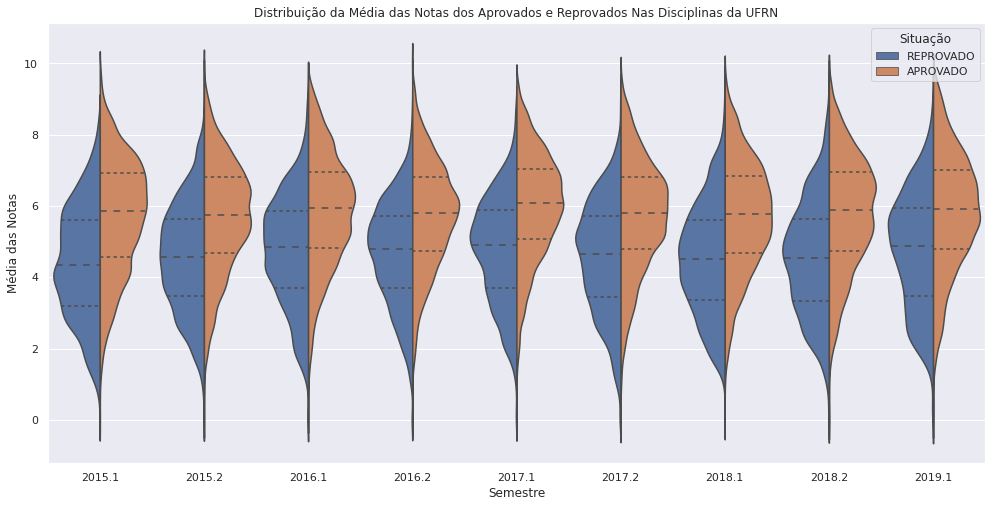

In [0]:
ax = sns.violinplot(x = 'semestrePassado', y = 'mediaNotas', hue = 'Situação',
               split=True, inner = 'quart', width = 0.9, 
               data = df_treino.rename(columns = {'situacao':'Situação'}))
ax.set_title('Distribuição da Média das Notas dos Aprovados e Reprovados Nas Disciplinas da UFRN')
ax.set_xlabel('Semestre')
ax.set_ylabel('Média das Notas')
sns.set(rc={'figure.figsize':(16.8,8.1)})

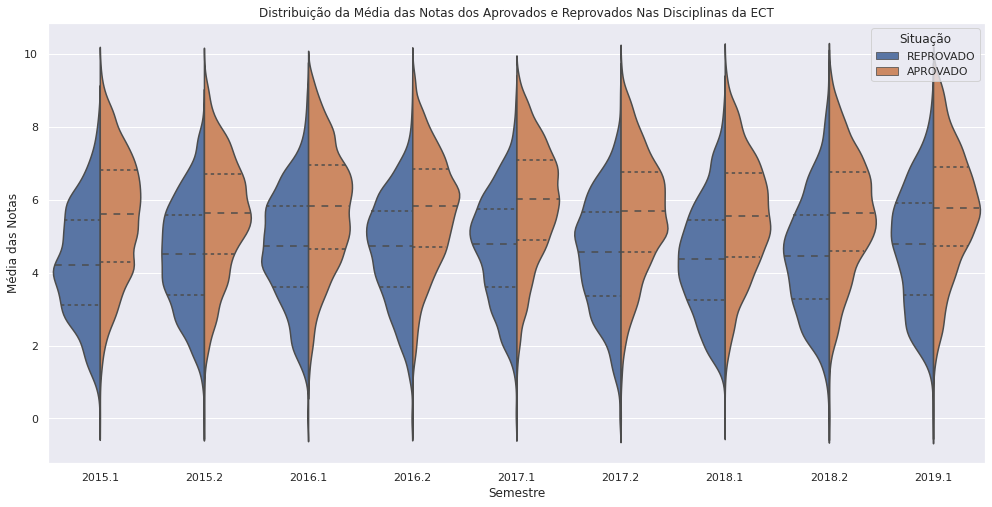

In [0]:
ax = sns.violinplot(x = 'semestrePassado', y = 'mediaNotas', hue = 'Situação',
               split=True, inner = 'quart', width = 0.9, 
               data = df_ect.rename(columns = {'situacao':'Situação'}))
ax.set_title('Distribuição da Média das Notas dos Aprovados e Reprovados Nas Disciplinas da ECT')
ax.set_xlabel('Semestre')
ax.set_ylabel('Média das Notas')
sns.set(rc={'figure.figsize':(16.8,8.1)})

Taxa de Sucesso X Situação nas Disciplinas no semestre seguinte, ao longo de todos os semestres

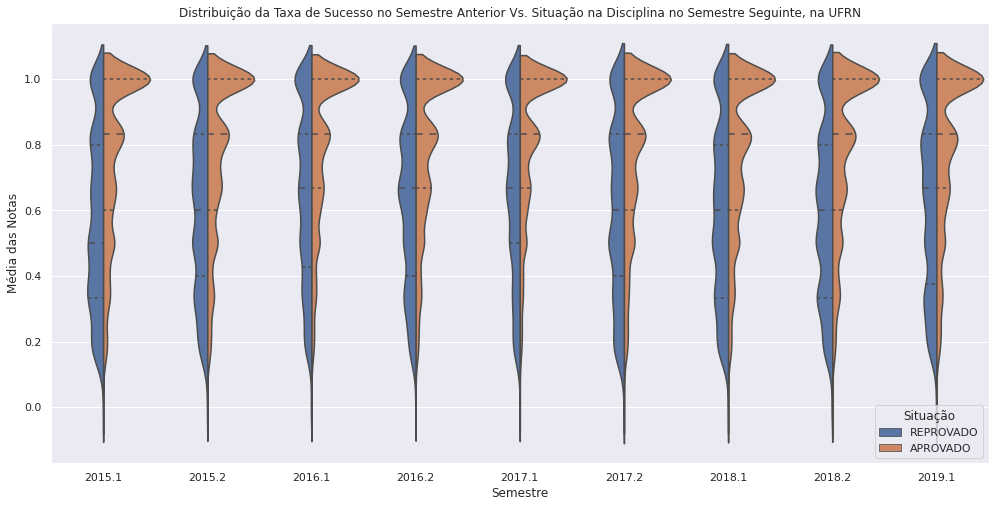

In [0]:
ax = sns.violinplot(x = 'semestrePassado', y = 'taxaDeSucesso', hue = 'Situação',
               split=True, inner = 'quart', width = 0.9, 
               data = df_treino.rename(columns = {'situacao':'Situação'}))
ax.set_title('Distribuição da Taxa de Sucesso no Semestre Anterior Vs. Situação na Disciplina no Semestre Seguinte, na UFRN')
ax.set_xlabel('Semestre')
ax.set_ylabel('Média das Notas')
sns.set(rc={'figure.figsize':(16.8,8.1)})

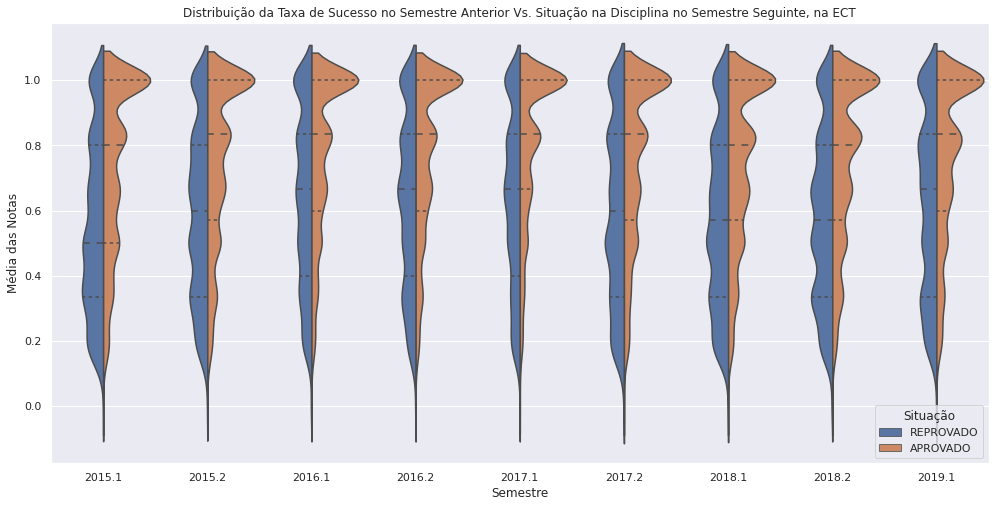

In [0]:
ax = sns.violinplot(x = 'semestrePassado', y = 'taxaDeSucesso', hue = 'Situação',
               split=True, inner = 'quart', width = 0.9, 
               data = df_ect.rename(columns = {'situacao':'Situação'}))
ax.set_title('Distribuição da Taxa de Sucesso no Semestre Anterior Vs. Situação na Disciplina no Semestre Seguinte, na ECT')
ax.set_xlabel('Semestre')
ax.set_ylabel('Média das Notas')
sns.set(rc={'figure.figsize':(16.8,8.1)})

Colunas a serem analisadas no gráfico

In [0]:
col_graph = ['taxaDeSucesso','mediaAprovadas','mediaReprovadas','mediaNotas','menorNota','maiorNota']                                                                                                                                                                                                 

In [0]:
df_graph_ect = df_ect.groupby(by=['semestrePassado','matricula']).mean()[col_graph].reset_index()

In [0]:
df_graph = df_treino.groupby(by=['semestrePassado','matricula']).mean()[col_graph].reset_index()

In [0]:
df_graph.head(2)

,semestrePassado,matricula,taxaDeSucesso,mediaAprovadas,mediaReprovadas,mediaNotas,menorNota,maiorNota
0,2015.1,2009028457,0.5,5.900000,2.0,3.950000,0.0,6.1
1,2015.1,2009029488,0.5,6.266667,1.8,4.033333,0.0,7.2


Distribuição da Taxa de Sucesso dos Estudantes ao Longo dos Semestres na UFRN

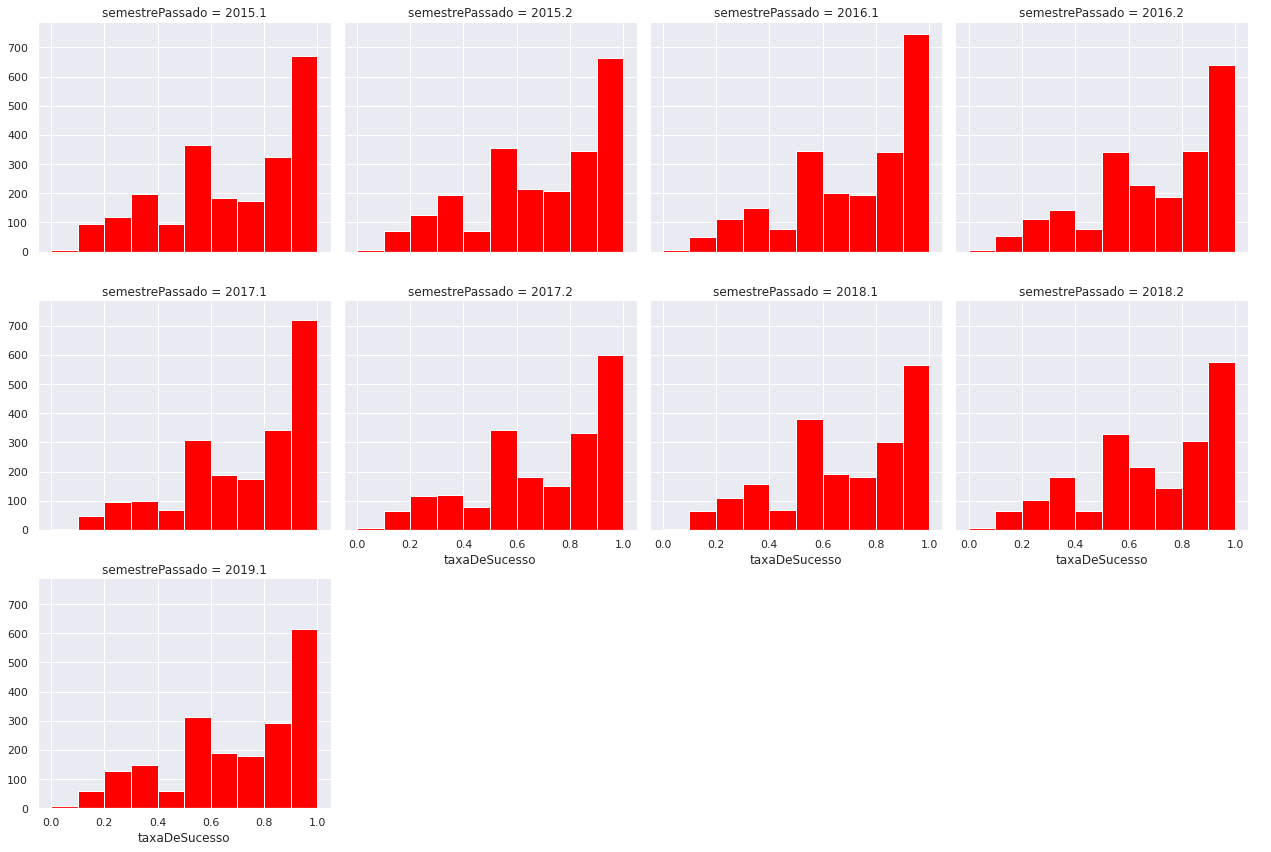

In [0]:
ax = sns.FacetGrid(df_graph, col = 'semestrePassado',margin_titles=False,size=4,aspect=1.1,col_wrap=4)
ax = (ax.map(plt.hist,'taxaDeSucesso',color="red").add_legend())

Distribuição da Taxa de Sucesso dos Estudantes ao Longo dos Semestres na ECT

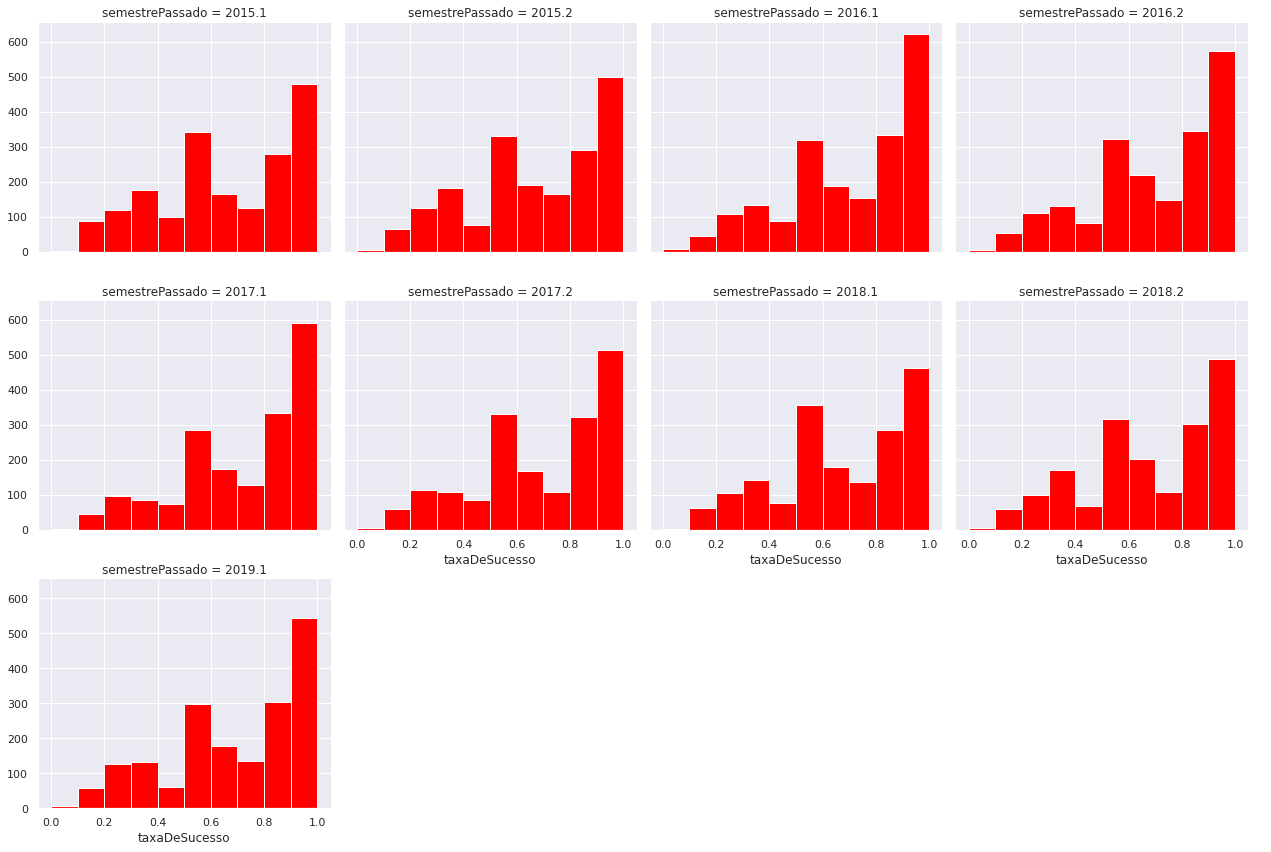

In [0]:
ax = sns.FacetGrid(df_graph_ect, col = 'semestrePassado',margin_titles=False,size=4,aspect=1.1,col_wrap=4)
ax = (ax.map(plt.hist,'taxaDeSucesso',color="red").add_legend())

##4. Métricas de Avaliação
<a id='metricas'></a>

Explicação e exemplos a seguir foram tirados do livro de referência

#### <center>Matriz de Confusão:
| VP |  | FN |
| --- | --- |--- |
| FP | | VN |

Composição da Matriz de Confusão

* Verdadeiros Positivos (VP)
* Falsos Positivos (FP)
* Verdadeiros Negativos (VN)
* Falsos Negativos (FN)

Se a predição cai na classe Positivo, quer dizer que o modelo acertou ao dizer que o verdadeiros eram realmente verdadeiros, VP, ou que os falsos eram realmente falsos, VN

Já se cai na classe Negativo, quer dizer que o modelo errou na predição, a suposição que era negativo quando na verdade era positivo, FN, ou quando era positivo e ele previu negativo, FP





---



**Acurácia**: 
É a taxa de previsões corretas, total de acertos/total de predições. Aparentemente uma boa métrica de avaliação não é?
O livro da o seguinte exemplo: um conjunto de dados com exemplos de caractéres escritos a mão, de '0' a '9'. Se criassemos um classificador para saber se era um '5', teria provavelmente uma boa acurácia, a do exemplo conseguiu atingir +95%.
Mas, temos um problema, como 10% das imagens são '5', se o classificador chutar qualquer outro número ele estaria certo em 90% das vezes. Isso demonstra que essa não é a das melhores métricas de classificação

Acurácia = (VP + VN) / Total

**Precisão**: A precisão pode ser interpretada como: dos que eu classifiquei como positivo, quantos eram realmente certos?

Precisão = VP / (VP + FP)

**Recall**: O recall nos diz com que frequência o classificador está encontrando exemplos de uma classe. Se for realmente dessa classe, o quanto frequente você classifica como ela? 

Recall = VP / (VP + FN)

**F1**: O F1 score combina o recall com a precisão de modo que tragam um único número. Favorece quando tem precisão e recall parecidos

F1 = (2 * Precisão * Recall) / (Precisão + Recall)

Utilizar essas métricas varia de problema e problema. O livro da o seguinte exemplo: 



Se você treinou um classificador para detectar vídeos que são adequados para crianças, provavelmente preferiria um classificador que rejeitasse muitos bons vídeos (baixo recall), mas mantivesse somente os adequados (alta precisão). Por outro lado, suponha que você treine um classificador para detectar bandidos nas imagens do sistema de segurança: é provavelmente tranquilo se seu classificador tiver uma precisão de apenas 30%, desde que tenha 99% de recall (com certeza os guardas de segurança receberão alguns alertas falsos, mas quase todos os ladrões serão pegos).



---



As curvas ROC e AUC estão entre as métricas mais utilizadas para avaliar um modelo de Machine Learning

**ROC**: É uma curva de probabilidade. Ela consegue definir quão bem um modelo criado pode destinguir entre 2 coisas. 

A Curva ROC tem 2 parâmetros, são eles:
* Taxa de Verdadeiro Positivo (Precisão) = VP / (VP + FN)
* Taxa de Falso Positivo = FP / (FP + VN). A taxa de falsos positivos também é conhecida como probabilidade de alarme falso

A curva ROC traça um Taxa de Verdadeiro Positivo vs Taxa de Falso Positivo em diferentes limiares de classificação

Para simplificar a curva ROC foi criada a curva **AUC**. A AUC resume a curva ROC num único valor, calculando a área sob a curva (Integral)

Quanto maior os valores de ROC e AUC melhor o modelo é

##5. Modelagem
<a id='modelagem'></a>

Lista de modelos disponíveis

* RandomForest
* KNeighbordsClassifier
* SVC linear
* GaussianNB
* MLPClassifier
* XGBClassifier
* LogisticRegression
* DecisionTreeClassifier
* AdaBoostClassifier


Dicionário com hiper-parâmetros dos algoritmos preditivos

In [0]:
hyperparameters = [
                  {'clf':[RandomForestClassifier()],
                  'clf__n_estimators': [100],
                  'clf__criterion': ['entropy'],
                  'clf__max_leaf_nodes': [64],
                  'clf__random_state': [42],
                  'fs__score_func':[chi2],
                  'fs__k':[4,9,15,30]
                  },
              
                  {'clf':[KNeighborsClassifier()],
                  'clf__n_neighbors':[5,9,11],
                  'fs__score_func':[chi2],
                  'fs__k':[4,9,15,30]                 
                  },
              
                  {'clf':[SVC()],
                  'clf__kernel':['sigmoid','rbf'],
                  'clf__degree':[3,4],
                  'clf__gamma':[0.1,0.5,1],
                  'clf__C':[0.001,1,2],
                  'fs__score_func':[chi2],
                  'fs__k':[4,9,15,25,31] 
                  },
              
                  {'clf':[GaussianNB()]
                  },
              
                  {'clf':[MLPClassifier()],
                  'clf__hidden_layer_sizes': [(64,),(128,)],
                  'clf__activation': ['logistic'],
                  'clf__solver': ['sgd'],
                  'clf__max_iter': [500],
                  'clf__early_stopping':[True],
                  'clf__n_iter_no_change':[20],
                  'clf__validation_fraction':[0.20], 
                  },
              
                  {'clf':[XGBClassifier()],
                  'clf__n_estimators': [50,100],
                  'clf__max_depth': [4,6],
                  'clf__learning_rate': [0.001, 0.01,0.1],
                  'clf__random_state': [42],
                  'clf__subsample': [1.0],
                  'clf__colsample_bytree': [1.0],
                  'fs__score_func':[chi2],
                  'fs__k':[5,8,15,25,31]
                  },
                   
                  {'clf':[LogisticRegression()],
                  'clf__random_state': [42],
                  'clf__C':[0.5,1,2]
                  },
                   
                  {'clf':[DecisionTreeClassifier()],
                  'clf__random_state': [42]
                  },
                   
                  {'clf':[AdaBoostClassifier()],
                  'clf__random_state': [42]
                  },

  ]

##6. Avaliação de Modelos
<a id='avaliacao'></a>

### [6.1 Explicação da Função de Treinamento](#explicacao)
### [6.2 Chamada da Função](#chamada)
### [6.3 Avaliação dos Modelos](#avaliacao)
### [6.4 Download Arquivos Importantes](#download)
### [6.5 Teste dos Modelos](#teste_modelos)

###6.1 Explicação da Função de Treinamento
<a id='explicacao'></a>

**Início da Função**

A função vai iterar sobre cada código de disciplina disponível, assim teremos um modelo para cada disciplina


**Componentes da Função**

O *Cross Validation* divide o conjunto em K partes, sendo k-1 partes para treino e a parte restante usa para avaliar o modelo. Repetindo esse processo K vezes. O número de K partes escolhido foi 5

O *Grid Search CV* faz o teste com todos os hiperparâmetros até encontrar a melhor combinação de valores que a medida de desempenho indique, que no nosso caso vai ser a curva AUC. Além disso ele suporta a integração com o Cross Validation e também com Pipelines

Antes da função treinar o Grid Search executa o pipeline de transformação, onde ele vai selecionar os 10 melhores atributos usando o chi2 (chi quadrado) e depois fazer uma padronização nos valores do dataframe usando o StandardScaler, que vai normalizar os dados, os deixando entre 0 e 1, sendo 0 a média e 1 o desvio-padrão. Assim retirando um possível viés que possa ter os dados se tiver valores discrepantes


**Relatório e Melhores Parâmetros** 

O Grid Search disponibiliza um relátorio informando todos os parâmetros usados em cada teste, transformamos para dataframe e selecionamos as colunas desejadas, que são: média no treino e no teste, std no treino e no teste, para todas as métricas escolhidas, que são elas: AUC, Recall, Precision e F1 

Ainda é criada uma coluna extra, std ratio, para a nossa principal medida, a curva AUC, que é o std do treino dividido pelo do teste

Com as colunas selecionadas, é concatenado a um dataframe que vai armazenar os relátorio de cada modelo, também é salvo os parâmetros de cada modelo

No fim de todas as iterações, é retornado um relatório e um dicionário com os melhores parâmetros de cada modelo

**Joblib - Persistência em Disco**

Depois do Grid Search descobrir o melhor modelo com base na métrica, é feita a persistência em disco do modelo usando o Joblib, ele é usado para serializar objetos Python com matrizes NumPy, sendo mais eficiente que o Pickle padrão do Python

O formato para salvar foi definido como: 'modelo_' + código da disciplina + '.pkl'

###6.2 Chamada da Função
<a id='chamada'></a>

In [21]:
df_treino.sample(2)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,codigo,disciplina,situacao,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
30379,2015015451,4.85,1.0,7.9,6,4,2,6.325,1.9,330.0,0.666667,2016.1,2015.0,1,ECT2207,PROBABILIDADE E ESTATÍSTICA,APROVADO,420.0,2016.2,6,0,baixa,alta,baixa,media,baixa,alta,media,1
85133,20180039410,6.02,5.0,7.0,5,5,0,6.020,0.0,285.0,1.000000,2018.2,2018.0,0,ECT2303,LINGUAGEM DE PROGRAMAÇÃO,APROVADO,330.0,2019.1,6,0,media,alta,media,media,baixa,media,media,1


In [22]:
df_predict.sample(2)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anosMatriculado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaPassada_cat
5032,2014085470,4.82,1.2,7.1,5,4,1,5.725,1.2,240.0,0.8,2015.2,1,baixa,alta,baixa,media,baixa,baixa
16858,20150127826,0.00,0.0,0.0,3,0,3,0.000,0.0,150.0,0.0,2017.2,2,baixa,baixa,baixa,baixa,baixa,baixa


Selecionando apenas uma disciplina afim de teste. Para rodar tudo tem que rodar com df_treino inteiro ou chamar a função de escolher as disciplinas apenas da ECT

In [0]:
df_teste = df_treino.loc[(df_treino['codigo'].str.contains('ECT2205')) | (df_treino['codigo'].str.contains('ECT2404'))]

In [0]:
#df_teste = selecionaDisciplinasECT(df_treino)

In [24]:
df_teste.head(3)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anoIngresso,anosMatriculado,codigo,disciplina,situacao,cargaHorariaAtual,semestreAtual,quantidadeDisciplinasAtuais,vezesReprovado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaAtual_cat,cargaHorariaPassada_cat,situacao_binarie
239,2010039386,1.22,0.0,5.9,5,1,4,5.900000,0.05,260.0,0.200000,2015.1,2010.0,5,ECT2205,PRÁTICAS DE LEITURA E ESCRITA II,REPROVADO,305.0,2015.2,5,1,baixa,media,baixa,media,baixa,media,baixa,0
2197,2012921104,5.70,0.0,8.0,6,5,1,6.840000,0.00,420.0,0.833333,2015.1,2012.0,3,ECT2205,PRÁTICAS DE LEITURA E ESCRITA II,REPROVADO,390.0,2015.2,7,0,baixa,alta,media,media,baixa,media,alta,0
2410,2012922540,4.74,0.7,8.4,5,3,2,6.166667,2.60,270.0,0.600000,2015.1,2012.0,3,ECT2205,PRÁTICAS DE LEITURA E ESCRITA II,APROVADO,420.0,2015.2,7,0,baixa,alta,baixa,media,baixa,alta,baixa,1


In [25]:
df_teste['codigo'].unique()

array(['ECT2205'], dtype=object)

In [0]:
(df_relatorio, model_param_disciplinas) = avaliar_modelos(df_teste, hyperparameters)

###6.3 Avaliação dos Modelos
<a id='avaliacao'></a>

In [27]:
model_param_disciplinas

{'ECT2205': LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False)}

In [28]:
df_relatorio

,codigo,AUC,mean_test_AUC,std_test_AUC,mean_train_AUC,std_train_AUC,rank_test_AUC,mean_train_F1,mean_test_F1,std_test_F1,std_train_F1,mean_train_Recall,mean_test_Recall,std_test_Recall,std_train_Recall,mean_train_Precision,mean_test_Precision,std_test_Precision,std_train_Precision,std_ratio,colunas_predicao
0,ECT2205,0.759808,0.759808,0.023165,0.76598,0.012166,1,0.858412,0.853281,0.003136,0.00093,0.936356,0.927937,0.015587,0.003672,0.792469,0.790084,0.011559,0.003259,1.903973,"[mediaNotas, menorNota, quantidadeAprovacoes, ..."


Dados para teste

In [0]:
codigo = 'ECT2201'
matricula = '2016019974'

Parâmetros escolhidos pelo chi2 para o modelo da linha 0

In [30]:
list(df_relatorio.iloc[0,-1])

['mediaNotas',
 'menorNota',
 'quantidadeAprovacoes',
 'quantidadeReprovacoes',
 'cargaHorariaPassada',
 'anosMatriculado',
 'maiorNota_cat_1',
 'mediaNotas_cat_2',
 'mediaAprovadas_cat_2']

Pipeline para tratar os dados finais de predição

In [0]:
pipeline_predicao = Pipeline(steps = [('etp', EncodingTreinamentoPredicao(coluna_drop = 'cargaHorariaAtual_cat')),
                                      ('scp', SelecionaColunasParaPredicao(relatorio = df_relatorio, 
                                                                           codigo = codigo,
                                                                           matricula = matricula))
                             ])

###6.4 Download Arquivos Importantes
<a id='download'></a>

**Importante, usar o joblib versão 0.15.1 para evitar incompatibilidades**

In [35]:
joblib.dump(pipeline_predicao, 'pipeline_predicao.pkl')

['pipeline_predicao.pkl']

In [0]:
df_treino.to_csv('df_treino.csv')

In [0]:
df_predict.to_csv('df_predicao.csv')

In [0]:
df_relatorio.to_csv('df_relatorio.csv')

###6.5 Teste dos Modelos
<a id='teste_modelos'></a>

Carregando Modelo treinado

In [0]:
model = joblib.load('modelo_ECT2205.pkl')

In [39]:
df_predict.sample(3)

,matricula,mediaNotas,menorNota,maiorNota,quantidadeDisciplinasCursadas,quantidadeAprovacoes,quantidadeReprovacoes,mediaAprovadas,mediaReprovadas,cargaHorariaPassada,taxaDeSucesso,semestrePassado,anosMatriculado,menorNota_cat,maiorNota_cat,mediaNotas_cat,mediaAprovadas_cat,mediaReprovadas_cat,cargaHorariaPassada_cat
8120,2015015513,7.666667,5.7,9.1,6,6,0,7.666667,0.0,315.0,1.000000,2016.1,1,media,alta,alta,alta,baixa,media
6603,2012922335,5.100000,4.7,5.4,3,2,1,5.300000,4.7,195.0,0.666667,2016.1,4,baixa,media,media,media,baixa,baixa
16758,2016098280,6.240000,3.8,7.8,5,4,1,6.850000,3.8,270.0,0.800000,2017.2,1,baixa,alta,media,media,baixa,baixa


Transformação final antes da predição

In [0]:
resultado = pipeline_predicao.transform(df_predict)
resultado

Predição

In [0]:
model.predict_proba(resultado)

##7. Conclusão
<a id='conclusao'></a>

Podemos dizer que este projeto foi bem sucessido. Dado a boa taxa de acertos dos modelos, podemos amenizar o problema do suporte ao professor que não tem meios de acompanhar fielmente todos os alunos, pelo fato de orientar muitos estudantes. Agora com esses modelos o professor pode tomar uma decisão mais segura baseada no histórico escolar do aluno, e também no histórico de outros estudantes na disciplina escolhida

O passo seguinte é a implementação de um WebApp onde o professor vai poder consultar esses modelos e receber um dashboard com informações gerais e com a predição do modelo